In [1]:
#* Cargamos las paqueterias necesarias
import pandas as pd
import boto3
import awswrangler as wr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import streamlit as st

session = boto3.Session(profile_name='arquitectura')
s3 = session.client('s3')

#* Agregamos las especificaciones necesarias
database_name = "econ"

In [9]:
#* Generamos un join con las tres tablas que creamos y lo guardamos en un dataframe
query = '''
SELECT COALESCE(tc.timestamp, ti.timestamp, inf.timestamp) AS date,
       tc.tipo_de_cambio as tipo_de_cambio,
       ti.tasa_interes as tasa_interes,
       inf.inflacion as inflacion
FROM econ.tipo_de_cambio tc
INNER JOIN econ.tasa_interes ti on tc.timestamp=ti.timestamp
INNER JOIN econ.inflacion as inf ON COALESCE(tc.timestamp, ti.timestamp) = inf.timestamp;
'''

data = wr.athena.read_sql_query(query, database=database_name, ctas_approach=False, boto3_session=session)
data.head(5)

#Guardamos la inf en un data_frame
data.to_csv('raw/data_w3.csv', index=False)

In [10]:
try:
    data['date'] = pd.to_datetime(data['date'])
    data['tasa_interes'] = pd.to_numeric(data['tasa_interes'], errors='coerce')
    data['tipo_de_cambio'] = pd.to_numeric(data['tipo_de_cambio'], errors='coerce')
    data['inflacion'] = pd.to_numeric(data['inflacion'], errors='coerce')
    # Limpieza de datos
    for col in ['tasa_interes', 'tipo_de_cambio', 'inflacion']:
        if col in data.columns:
            data[col] = data[col].astype(str).str.strip()  # Elimina espacios en blanco
            data[col] = data[col].str.replace(',', '.', regex=False) #Reemplazar comas por puntos.
            data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Eliminar filas con valores NaN
    data = data.dropna()
    print(data.dtypes)
    print(data.head())
except KeyError as e:
    print(f"Error: Columna faltante en el DataFrame: {e}")
except ValueError as e:
    print(f"Error: Problema al convertir datos: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")

data.head(5)



date              datetime64[ns]
tipo_de_cambio           float64
tasa_interes             float64
inflacion                float64
dtype: object
        date  tipo_de_cambio  tasa_interes  inflacion
0 2008-01-01             3.0           3.0        3.0
1 2008-02-01             3.0          10.0       10.0
2 2008-02-01             3.0          10.0        7.0
3 2008-02-01             3.0          10.0        3.0
4 2008-02-01             3.0           7.0       10.0


,date,tipo_de_cambio,tasa_interes,inflacion
0,2008-01-01,3.0,3.0,3.0
1,2008-02-01,3.0,10.0,10.0
2,2008-02-01,3.0,10.0,7.0
3,2008-02-01,3.0,10.0,3.0
4,2008-02-01,3.0,7.0,10.0


In [11]:
def realizar_regresion(x, y):
    x = sm.add_constant(x)
    modelo = sm.OLS(y, x).fit()
    return modelo

def graficar_regresion(x, y, modelo, titulo):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.plot(x, modelo.predict(sm.add_constant(x)), color='red')
    ax.set_title(titulo)
    return fig


In [12]:
# Regresiones
modelo_tc_ti = realizar_regresion(data['tasa_interes'],data['tipo_de_cambio'])
modelo_ti_inf = realizar_regresion(data['inflacion'], data['tasa_interes'])
modelo_tc_inf = realizar_regresion(data['inflacion'], data['tipo_de_cambio'])

2025-03-23 23:15:03.812 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.815 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-23 23:15:03.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

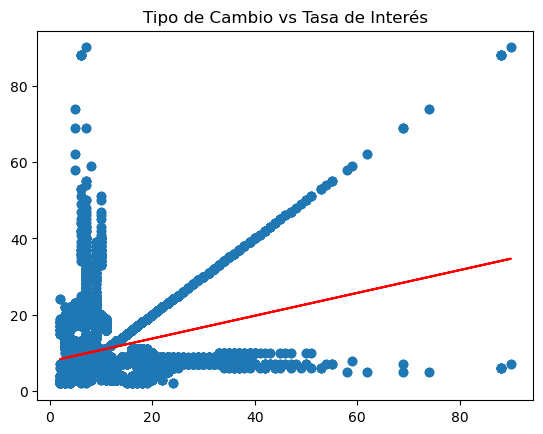

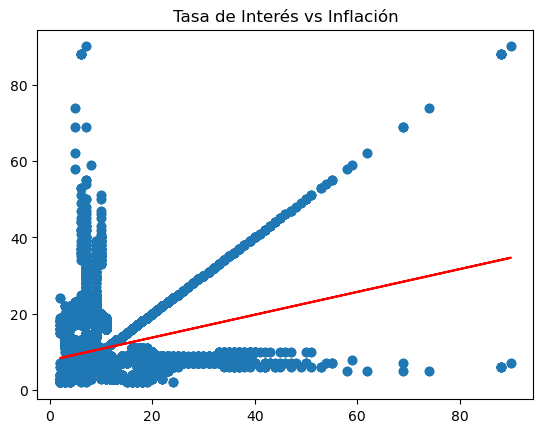

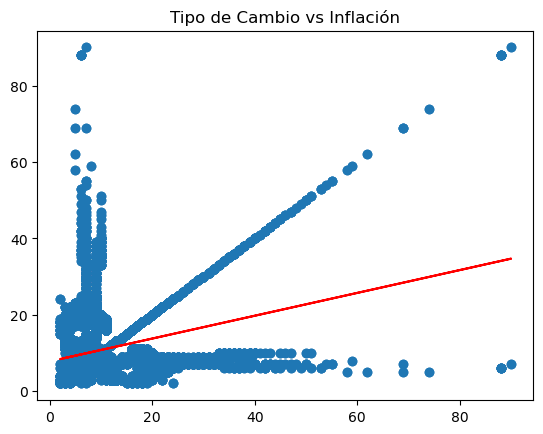

In [13]:
# Aplicación Streamlit
st.title('Regresiones Lineales')

st.write('Datos descargados de Athena:')
st.dataframe(data)

st.write('Regresión: Tipo de Cambio vs Tasa de Interés')
st.pyplot(graficar_regresion(data['tasa_interes'], data['tipo_de_cambio'], modelo_tc_ti, 'Tipo de Cambio vs Tasa de Interés'))

st.write('Regresión: Tasa de Interés vs Inflación')
st.pyplot(graficar_regresion(data['inflacion'], data['tasa_interes'], modelo_ti_inf, 'Tasa de Interés vs Inflación'))

st.write('Regresión: Tipo de Cambio vs Inflación')
st.pyplot(graficar_regresion(data['inflacion'], data['tipo_de_cambio'], modelo_tc_inf, 'Tipo de Cambio vs Inflación'))